# ライブラリ

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# matplotlib日本語化
!pip install japanize-matplotlib
import japanize_matplotlib
japanize_matplotlib.japanize()

# warningsを表示しない
import warnings
warnings.filterwarnings("ignore")

# 4.1 DID（差分の差分法）

## 4.1.3 DIDのアイデアを用いた集計分析

In [25]:
# データセット作成（Data from Table.12 in Snow(1855): http://www.ph.ucla.edu/epi/snow/table12a.html）

# Southwark and Vauxhall社，1849年
sv1849 = pd.DataFrame({
    "area": ["sv_1", "sv_2", "sv_3", "sv_4", "sv_5", "sv_6", "sv_7", "sv_8", "sv_9", "sv_10", "sv_11", "sv_12"], 
    "year": [1849] * 12, 
    "death": [283, 157, 192, 249, 259, 226, 352, 97, 111, 8, 235, 92], 
    "LSV": [0] * 12, 
    "company": ["Southwark and Vauxhall"] * 12
})

# Southwark and Vauxhall社，1854年
sv1854 = pd.DataFrame({
    "area": ["sv_1", "sv_2", "sv_3", "sv_4", "sv_5", "sv_6", "sv_7", "sv_8", "sv_9", "sv_10", "sv_11", "sv_12"], 
    "year": [1854] * 12, 
    "death": [371, 161, 148, 362, 244, 237, 282, 59, 171, 9, 240, 174], 
    "LSV": [0] * 12, 
    "company": ["Southwark and Vauxhall"] * 12
})

# Lambeth社 & Southwark and Vauxhall社，1849年
lsv1849 = pd.DataFrame({
    "area": ["lsv_1", "lsv_2", "lsv_3", "lsv_4", "lsv_5", "lsv_6", "lsv_7", "lsv_8", "lsv_9", "lsv_10", "lsv_11", "lsv_12", "lsv_13", "lsv_14", "lsv_15", "lsv_16"], 
    "year": [1849] * 16, 
    "death": [256, 267, 312, 257, 318, 446, 143, 193, 243, 215, 544, 187, 153, 81, 114, 176], 
    "LSV": [1] * 16, 
    "company": ["Lambeth & Southwark and Vauxhall"] * 16
})

# Lambeth社 & Southwark and Vauxhall社，1854年
lsv1854 = pd.DataFrame({
    "area": ["lsv_1", "lsv_2", "lsv_3", "lsv_4", "lsv_5", "lsv_6", "lsv_7", "lsv_8", "lsv_9", "lsv_10", "lsv_11", "lsv_12", "lsv_13", "lsv_14", "lsv_15", "lsv_16"], 
    "year": [1854] * 16, 
    "death": [113, 174, 270, 93, 210, 388, 92, 58, 117, 49, 193, 303, 142, 48, 165, 132], 
    "LSV": [1] * 16, 
    "company": ["Lambeth & Southwark and Vauxhall"] * 16
})

# マージ
JS_df = pd.concat([sv1849, sv1854, lsv1849, lsv1854]).reset_index(drop = True)
JS_df.head()

,area,year,death,LSV,company
0,sv_1,1849,283,0,Southwark and Vauxhall
1,sv_2,1849,157,0,Southwark and Vauxhall
2,sv_3,1849,192,0,Southwark and Vauxhall
3,sv_4,1849,249,0,Southwark and Vauxhall
4,sv_5,1849,259,0,Southwark and Vauxhall


In [26]:
# 集計（P.140）
JS_grp_summary = pd.pivot_table(JS_df, values = "death", index = ["company", "LSV"], columns = "year", aggfunc = "sum")
JS_grp_summary["gap"] = JS_grp_summary[1854] - JS_grp_summary[1849]
JS_grp_summary["gap_rate"] = JS_grp_summary["gap"] / JS_grp_summary[1849]
JS_grp_summary

,year,1849,1854,gap,gap_rate
company,LSV,,,,
Lambeth & Southwark and Vauxhall,1,3905,2547,-1358,-0.347759
Southwark and Vauxhall,0,2261,2458,197,0.087130


In [27]:
# 会社別のデータセットを作成
JS_sum = JS_df.groupby(["company", "LSV", "year"])["death"].sum().reset_index()
JS_sum["year"] = JS_sum["year"].astype(str)
JS_sum

,company,LSV,year,death
0,Lambeth & Southwark and Vauxhall,1,1849,3905
1,Lambeth & Southwark and Vauxhall,1,1854,2547
2,Southwark and Vauxhall,0,1849,2261
3,Southwark and Vauxhall,0,1854,2458


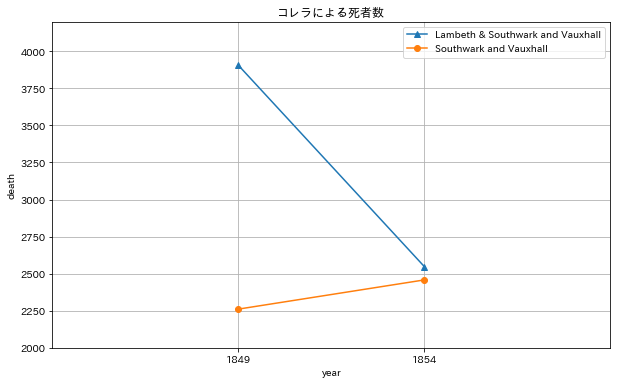

In [28]:
# 図4.2: 集計による分析の可視化
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(JS_sum[JS_sum["LSV"] == 1]["year"], JS_sum[JS_sum["LSV"] == 1]["death"], marker = "^", label = "Lambeth & Southwark and Vauxhall")
ax.plot(JS_sum[JS_sum["LSV"] == 0]["year"], JS_sum[JS_sum["LSV"] == 0]["death"], marker = "o", label = "Southwark and Vauxhall")
ax.set_title("コレラによる死者数")
ax.set_ylabel("death")
ax.set_xlabel("year")
ax.set_xlim(-1,2)
ax.set_ylim(2000, 4200)
ax.legend(loc = "best")
ax.grid(True)

## 4.1.4 回帰分析を利用したDID

In [29]:
# ライブラリ
import statsmodels.api as sm

In [30]:
# 変数作成
JS_sum["D1854"] = JS_sum["year"].apply(lambda x : 1 if x == "1854" else 0)
JS_sum["D1854LSV"] = JS_sum["D1854"] * JS_sum["LSV"]
y = JS_sum["death"]
x = sm.add_constant(JS_sum[["LSV", "D1854", "D1854LSV"]])

# 回帰分析
JS_did = sm.OLS(y, x).fit()

# 結果を確認：係数推定値のみ
print(JS_did.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2261.0000        inf          0        nan         nan         nan
LSV         1644.0000        inf          0        nan         nan         nan
D1854        197.0000        inf          0        nan         nan         nan
D1854LSV   -1555.0000        inf         -0        nan         nan         nan


In [31]:
# エリアごとのデータでDID
JS_df["D1854"] = JS_df["year"].apply(lambda x : 1 if x == 1854 else 0)
JS_df["D1854LSV"] = JS_df["D1854"] * JS_df["LSV"]
x = JS_df[["LSV", "D1854", "D1854LSV", "area"]]
x = sm.add_constant(pd.get_dummies(x, columns = ["area"], drop_first = True))
y = JS_df["death"]

# 回帰分析
JS_did_area = sm.OLS(y, x).fit()
coef = JS_did_area.summary().tables[1]
coef = pd.read_html(coef.as_html(), header = 0, index_col = 0)[0]
coef.iloc[:4]

,coef,std err,t,P>|t|,[0.025,0.975]
const,177.7098,15.699,11.320,0.000,145.439,209.980
LSV,49.2277,44.742,1.100,0.281,-42.741,141.196
D1854,16.4167,25.347,0.648,0.523,-35.686,68.519
D1854LSV,-101.2917,33.532,-3.021,0.006,-170.217,-32.366


In [32]:
# 被説明変数を対数化して回帰
y = np.log(JS_df["death"])
JS_did_area_log = sm.OLS(y, x).fit()
coef = JS_did_area_log.summary().tables[1]
coef = pd.read_html(coef.as_html(), header = 0, index_col = 0)[0]
coef.iloc[:4]

,coef,std err,t,P>|t|,[0.025,0.975]
const,4.6461,0.082,56.471,0.000,4.477,4.815
LSV,0.7366,0.234,3.141,0.004,0.255,1.219
D1854,0.0739,0.133,0.556,0.583,-0.199,0.347
D1854LSV,-0.5667,0.176,-3.225,0.003,-0.928,-0.205


# 4.3 大規模禁煙キャンペーンがもたらすタバコの売上への影響

## 4.3.1 データの準備

In [33]:
# Cigarデータ
df = sm.datasets.get_rdataset("Cigar", "Ecdat").data
df.head()

,state,year,price,pop,pop16,cpi,ndi,sales,pimin
0,1,63,28.6,3383.0,2236.5,30.6,1558.304530,93.9,26.1
1,1,64,29.8,3431.0,2276.7,31.0,1684.073202,95.4,27.5
2,1,65,29.8,3486.0,2327.5,31.5,1809.841875,98.5,28.9
3,1,66,31.5,3524.0,2369.7,32.4,1915.160357,96.4,29.5
4,1,67,31.6,3533.0,2393.7,33.4,2023.546368,95.5,29.6


In [34]:
# Common Trend Assumptionのために分析から特定の州を外す
skip_state = [3, 9, 10, 22, 21, 23, 31, 33, 48]

# skip_stateに含まれる州のデータを削除
Cigar = df[(df["year"] >= 70) & (~df["state"].isin(skip_state))]
Cigar.head()

,state,year,price,pop,pop16,cpi,ndi,sales,pimin
7,1,70,39.6,3444.0,2394.6,38.8,2591.039159,89.8,34.3
8,1,71,42.7,3481.0,2443.5,40.5,2785.315971,95.4,35.8
9,1,72,42.3,3511.0,2484.7,41.8,3034.808297,101.1,37.4
10,1,73,42.1,3540.0,2526.0,44.4,3387.574086,102.9,37.3
11,1,74,43.1,3574.0,2573.9,49.3,3718.867175,108.2,41.4


## 4.3.2 DIDの実装

In [35]:
# 図4.5作成用データ
Cigar_temp = Cigar.copy()
Cigar_temp["area"] = Cigar_temp["state"].apply(lambda x : "CA" if x == 5 else "Rest of US")
Cigar_temp["period"] = Cigar_temp["year"].apply(lambda x : "before" if x <= 87 else "after")
Cigar_temp["sales_pop16"] = Cigar_temp["sales"] * Cigar_temp["pop16"]

# 集計
Cigar_mean = Cigar_temp.groupby(["area", "period"])["pop16", "sales_pop16"].mean().reset_index()
Cigar_mean["sales"] = Cigar_mean["sales_pop16"] / Cigar_mean["pop16"]
Cigar_mean

,area,period,pop16,sales_pop16,sales
0,CA,after,22355.320000,1.724154e+06,77.124997
1,CA,before,17674.250000,2.061836e+06,116.657645
2,Rest of US,after,2948.603889,3.151694e+05,106.887669
3,Rest of US,before,2605.420216,3.304769e+05,126.842072


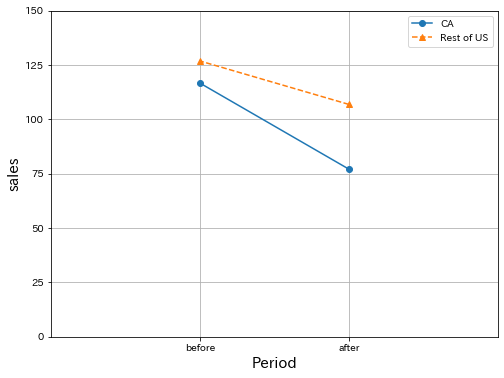

In [36]:
# 図4.5: タバコの売上の前後比較
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(Cigar_mean[Cigar_mean["area"] == "CA"]["period"], Cigar_mean[Cigar_mean["area"] == "CA"]["sales"], marker = "o", label = "CA")
ax.plot(Cigar_mean[Cigar_mean["area"] == "Rest of US"]["period"], Cigar_mean[Cigar_mean["area"] == "Rest of US"]["sales"], marker = "^", linestyle = "--", label = "Rest of US")
ax.set_ylabel("sales", size = 15)
ax.set_xlabel("Period", size = 15)
ax.set_xlim(-1,2)
ax.set_ylim(0, 150)
ax.set_yticks([0, 25, 50, 75, 100, 125, 150])
ax.legend(loc = "best")
ax.invert_xaxis()
ax.grid(True)

In [37]:
# DIDのためのデータを準備
Cigar["post"] = Cigar["year"].apply(lambda x : 1 if x > 87 else 0)
Cigar["ca"] = Cigar["state"].apply(lambda x : 1 if x == 5 else 0)
Cigar["sales_pop16"] = Cigar["sales"] * Cigar["pop16"]

# カリフォルニア州とそのほかという2グループのデータ
Cigar_did_sum = Cigar.groupby(["post", "year", "ca"], as_index = False)["pop16", "sales_pop16"].mean()
Cigar_did_sum["sales"] = Cigar_did_sum["sales_pop16"] / Cigar_did_sum["pop16"]
Cigar_did_sum["ca_post"] = Cigar_did_sum["ca"] * Cigar_did_sum["post"]
Cigar_did_sum.head()

,post,year,ca,pop16,sales_pop16,sales,ca_post
0,0,70,0,2268.744444,2.609811e+05,115.033284,0
1,0,70,1,14317.600000,1.761065e+06,123.000000,0
2,0,71,0,2319.763889,2.740049e+05,118.117568,0
3,0,71,1,14670.500000,1.775130e+06,121.000000,0
4,0,72,0,2360.625000,2.852985e+05,120.857179,0


In [38]:
# 2グループでのデータでの分析
y = Cigar_did_sum["sales"]
X = sm.add_constant(pd.get_dummies(Cigar_did_sum[["ca", "post", "ca_post", "year"]], columns = ["year"], drop_first = True))

# 回帰
Cigar_did_sum_reg = sm.OLS(y, X).fit()
coef = Cigar_did_sum_reg.summary().tables[1]

# 推定結果の表をデータフレーム可
coef = pd.read_html(coef.as_html(), header = 0, index_col = 0)[0]
coef.iloc[:4]

,coef,std err,t,P>|t|,[0.025,0.975]
const,123.5615,4.519,27.340,0.000,114.163,132.960
ca,-9.0898,2.074,-4.384,0.000,-13.402,-4.777
post,-13.8569,4.423,-3.133,0.005,-23.054,-4.660
ca_post,-20.5435,4.447,-4.619,0.000,-29.792,-11.295


In [39]:
# 目的変数に対数をとった場合
ly = np.log(Cigar_did_sum["sales"])

# 回帰
Cigar_did_sum_logreg = sm.OLS(ly, X).fit()
coef = Cigar_did_sum_logreg.summary().tables[1]

# 推定結果の表をデータフレーム可
coef = pd.read_html(coef.as_html(), header = 0, index_col = 0)[0]
coef.iloc[:4]

,coef,std err,t,P>|t|,[0.025,0.975]
const,4.8171,0.042,114.363,0.000,4.729,4.905
ca,-0.0767,0.019,-3.969,0.001,-0.117,-0.037
post,-0.1213,0.041,-2.944,0.008,-0.207,-0.036
ca_post,-0.2530,0.041,-6.105,0.000,-0.339,-0.167


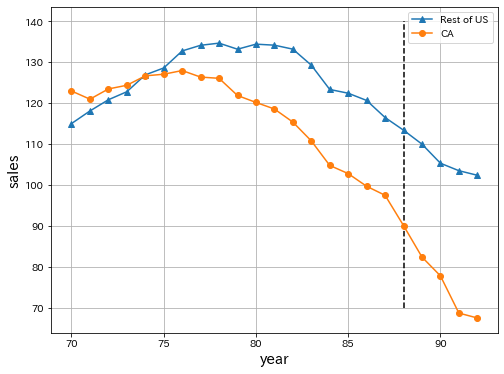

In [40]:
# 図4.6: 売上のトレンドの確認
fig, ax = plt.subplots(figsize = (8, 6))
ax.plot(Cigar_did_sum[Cigar_did_sum["ca"] == 0]["year"], Cigar_did_sum[Cigar_did_sum["ca"] == 0]["sales"], marker = "^", label = "Rest of US")
ax.plot(Cigar_did_sum[Cigar_did_sum["ca"] == 1]["year"], Cigar_did_sum[Cigar_did_sum["ca"] == 1]["sales"], marker = "o", label = "CA")
#plt.axvline(y = 0, linestyle = "dashed", color = "black", linewidth = 1)
ax.vlines(x = 88, ymin = 70, ymax = 140, linestyle = "--")
ax.set_ylabel("sales", size = 15)
ax.set_xlabel("year", size = 15)
ax.legend(loc = "best")
ax.grid(True)

## 4.3.3 CausalImpactの実装

### tfcausalimpactライブラリを使用

- 【参考】
 - 「Pythonで因果推論したい（CausalImpact）」https://esu-ko.hatenablog.com/entry/2020/08/13/Python%E3%81%A7%E5%9B%A0%E6%9E%9C%E6%8E%A8%E8%AB%96%E3%81%97%E3%81%9F%E3%81%84%28CausalImpact%29
- 【注】tfcausalimpact ( https://github.com/WillianFuks/tfcausalimpact )ではエラー：Input data is empty

In [41]:
# ライブラリ
!pip install pycausalimpact
from causalimpact import CausalImpact

In [42]:
# 目的変数
Y = Cigar[Cigar["state"] == 5][["year", "sales"]].set_index("year")
Y.columns = ["Y"]

# 共変量としてほかの州の売上を抜き出し整形
X_sales = pd.pivot_table(Cigar[Cigar["state"] != 5][["year", "state", "sales"]], values = "sales", index = "year", columns = "state").add_prefix("X_")

# 介入が行われるデータを示す
pre_period = [70, 87]
post_period = [88, 92]

# 目的変数と共変量をバインド
CI_data = pd.concat([Y, X_sales], axis = 1)

In [47]:
# CausalImpactによる分析
impact = CausalImpact(CI_data, pre_period, post_period)

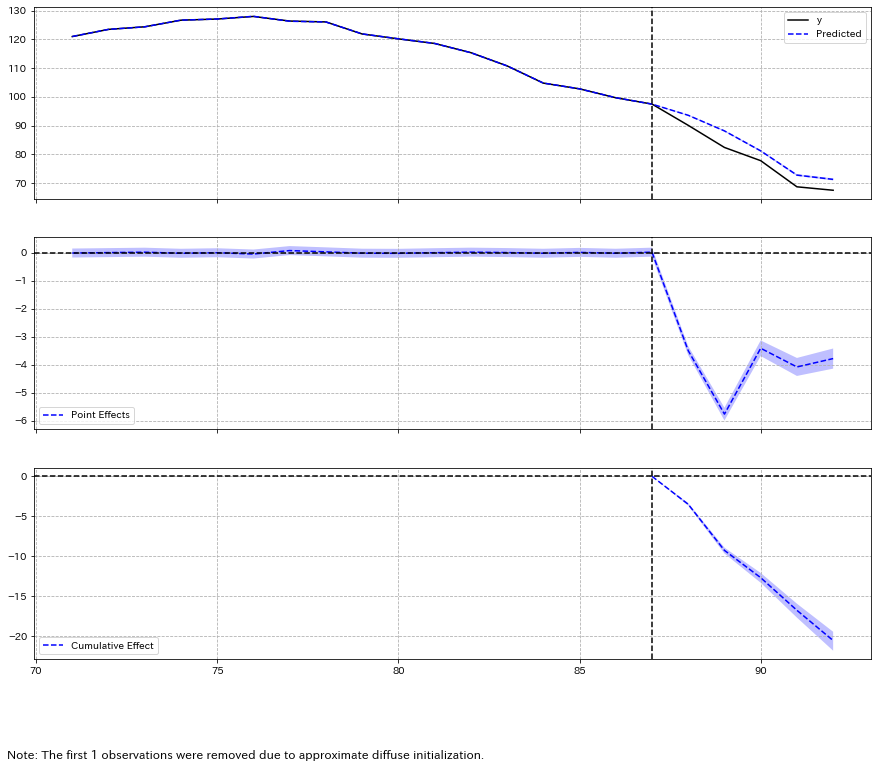

In [48]:
# 結果のplot
impact.plot()

In [45]:
# 推定された効果を実数と比率で確認
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    77.3               386.5
Prediction (s.d.)         81.4 (0.13)        407.02 (0.64)
95% CI                    [81.14, 81.64]     [405.7, 408.21]

Absolute effect (s.d.)    -4.1 (0.13)        -20.52 (0.64)
95% CI                    [-4.34, -3.84]     [-21.71, -19.2]

Relative effect (s.d.)    -5.04% (0.16%)     -5.04% (0.16%)
95% CI                    [-5.33%, -4.72%]   [-5.33%, -4.72%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [46]:
# 結果レポート生成
print(impact.summary(output = "report"))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 77.3. By contrast, in the absence of an
intervention, we would have expected an average response of 81.4.
The 95% interval of this counterfactual prediction is [81.14, 81.64].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -4.1 with a 95% interval of
[-4.34, -3.84]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 386.5.
By contrast, had the intervention not taken place, we would have expected
a sum of 407.02. The 95% interval of this prediction is [405.7, 408.21].


The above results are given in terms of absolute numbers. In relative
terms, the response variable sh